# Exploring Structural Tensor Implementation - Method Validation
## Sam Potter
## Current: 4/10/19

## Paths and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/psfdi'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
from psfdi import image_processing as imp
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.stats import beta
from scipy.stats import sem

## Magics

In [2]:
%matplotlib inline

# Synthetic Example

## Create Beta Distribution Data

### Statistics and theta ranges

In [3]:
mean1 = np.deg2rad(5)
sd1 = np.deg2rad(10)
mean2 = np.deg2rad(25)
sd2 = np.deg2rad(30)
theta = np.linspace(-np.pi, np.pi, 360)
d = 0.5

### Beta functions

In [4]:
def compute_beta(mean, sd, theta):
    
    mu = (mean + np.pi / 2) / np.pi

    sigma = sd / np.pi

    gamma = (mu**2 - mu**3-sigma**2 * mu) / (sigma**2)

    delta = gamma * (1 - mu) / mu

    y = (theta + np.pi / 2) / np.pi
       
    vals = beta.pdf(y, gamma, delta) / np.pi
    
    return vals    

In [15]:
def compute_gamma(mean1, sd1, mean2, sd2, d, theta):
    
    # Adust theta so it wraps around to the -pi/2 pi/2 interval
    local_theta = np.copy(theta)
    local_theta[local_theta < -np.pi / 2] = local_theta[local_theta < -np.pi / 2] + np.pi
    local_theta[local_theta > np.pi / 2] = local_theta[local_theta > np.pi / 2] - np.pi
    
    gamma1 = compute_beta(mean1, sd1, local_theta)
    gamma2 = compute_beta(mean2, sd2, local_theta)
    
    gamma = d * (gamma1 + gamma2) + (1 - d) / np.pi
    
    gamma_area = 0.0
    
    for i in range(1, len(theta)):
        gamma_area += 0.5 * (gamma[i] + gamma[i-1]) * (theta[i] - theta[i-1])
    
    return gamma / gamma_area

In [16]:
gamma = compute_gamma(mean1, sd1, mean2, sd2, d, theta)

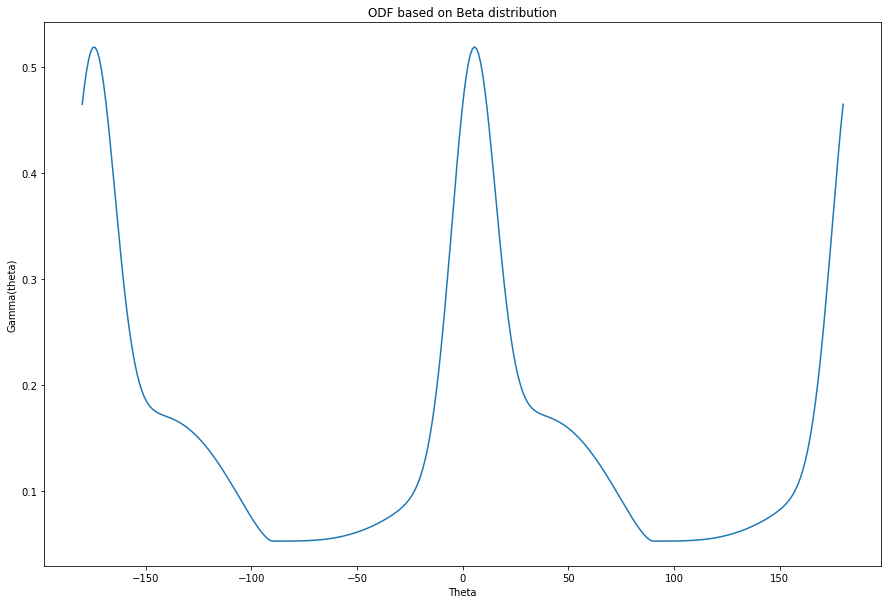

In [22]:
fig = plt.figure(figsize=(15, 10))
plt.plot(np.rad2deg(theta), gamma);
plt.xlabel('Theta')
plt.ylabel('Gamma(theta)')
plt.title('ODF based on Beta distribution');

## Fourier Fitting

In [23]:
def compute_an(order, gamma, theta):
    
    coeff = 0.0
    for i in range(1, len(theta)):
        coeff += 0.5 * (gamma[i] * np.cos(order * theta[i]) + gamma[i-1] * np.cos(order * theta[i-1])) * (theta[i] - theta[i-1])
        
    return 2 * coeff